In [ ]:
#@title
%%html
<iframe src="https://www.polskacyfrowa.gov.pl/media/48246/FE_POPC_poziom_pl-1_rgb.jpg" width="800"></iframe>


# Uczenie głębokie

Szymon Zaporowski, Politechnika Gdańska, Wydział ETI, Katedra Systemów Multimedialnych

**Wykład 15:** Modele Generatywne typu GAN

**Przykład (1):** Warunkowa sieć typu GAN

Generatywna Sieć Kontradyktoryjna **(GAN)** pozwala na generowanie nowych danych w postaci obrazów, video lub audio z wejścia będącego losowymi danymi. Zazwyczaj dane losowe będące wejściem jest próbkowane z rozkładu normalnego, zanim poprzez serię transformacji zostaną zamienione w coś zorumiałego dla człowieka ( obraz, audio, video itp.)

Prosta głeboka sieć typu GAN **(DCGAN)** nie pozwala na kontrolowanie wyglądu próbek (np. klasy), które generujemy. Przykładowo GAN generujący próbki z datasetu MNIST (przykład z laboratorium z modeli generatywnych), nie pozwala nam na wybranie klasy cyfr, które generujemy. Aby móc kontrolować, to co generujemy musimy kondycjonować wyjście sieci GAN na wyjściu semantycznym, takim jak klasa obrazu.

W tym przykładzie zbudujemy  **Warunkową sieć typu GAN** , która może generować odręczne pisane cyfry ze zbioru MNIST uwarunkowane na danej klasie. Taki model może mieć różne przydatne aplikacje:

* Powiedzmy, że masz do czynienia z niezbalansowanym zbiorem danych i chciałbyś zebrać więcej przykładów do klasy, która posiada mało próbek, aby zrównoważyć zestaw danych.
Zbieranie danych może być kosztownym procesem. Zamiast tego można wytrenować warunkowy GAN i użyć wygenerowanych przykładów dla klasy, która wymaga równoważenia.



In [ ]:
!pip install -q git+https://github.com/tensorflow/docs

Dokonajmy importu potrzebnych bibliotek


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow_docs.vis import embed
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import imageio

Ustawmy hiperparametry

In [ ]:
batch_size = 64
num_channels = 1
num_classes = 10
image_size = 28
latent_dim = 128

Załadujmy zbiór MNIST i dokonajmy skalowania oraz kodowania typu one-hot

In [ ]:
# Wykorzystamy wszystkie dostępne przykłady dla zbioru treningowego i testowego
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
all_digits = np.concatenate([x_train, x_test])
all_labels = np.concatenate([y_train, y_test])

# Przeskalujemy wartości pikseli do wartości [0,1] i doddamy wymiar kanału do obierów,
#oraz etykiety typu one-hot
all_digits = all_digits.astype("float32") / 255.0
all_digits = np.reshape(all_digits, (-1, 28, 28, 1))
all_labels = keras.utils.to_categorical(all_labels, 10)

# Tworzymy tf.data.Dataset.
dataset = tf.data.Dataset.from_tensor_slices((all_digits, all_labels))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

print(f"Kształt treningowych obrazów : {all_digits.shape}")
print(f"Kształt treningowych etykiet : {all_labels.shape}")

11501568/11490434 [==============================] - 1s 0us/step
Kształt treningowych obrazów : (70000, 28, 28, 1)
Kształt treningowych etykiet : (70000, 10)


## Obliczanie liczby kanałów wejściowych w generatorze i dyskryminatorze

W klasycznej (nieuwarunkowanej) sieci typu GAN, wektor wejściowy składa się z próbek szumu (o pewnej stałej długości) z rozkłądu normalnego. W przypadku GAN-a warunkowego nalezy wziąć również pod uwagę etykiety klas. W związku z tym nalezy dodać liczbę klas do kanałów wejściowych generatora (wejście szumu) oraz dyskryminatora (wejście generowanego obrazu).


In [ ]:
generator_in_channels = latent_dim + num_classes
discriminator_in_channels = num_channels + num_classes
print(generator_in_channels, discriminator_in_channels)

138 11


## Tworzenie dyskryminatora i generatora

Definicje modeli (`discriminator`, `generator`, oraz `ConditionalGAN`) zostały "zapożyczone" z [tego przykładu](https://keras.io/guides/customizing_what_happens_in_fit/).

In [ ]:
# Tworzenie dyskryminatora
discriminator = keras.Sequential(
    [
        keras.layers.InputLayer((28, 28, discriminator_in_channels)),
        layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.GlobalMaxPooling2D(),
        layers.Dense(1),
    ],
    name="discriminator",
)

# Tworzenie generatora
generator = keras.Sequential(
    [
        keras.layers.InputLayer((generator_in_channels,)),
        # Chcemy wygenerwoać liczbę współczynników równą 128 + liczba klas
        # i dokonać reshape do mapy o wymiarach 7x7x(128 + num_classes)
        layers.Dense(7 * 7 * generator_in_channels),
        layers.LeakyReLU(alpha=0.2),
        layers.Reshape((7, 7, generator_in_channels)),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(1, (7, 7), padding="same", activation="sigmoid"),
    ],
    name="generator",
)

Tworzymy model warunkowy sieci GAN

In [ ]:

class ConditionalGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(ConditionalGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(ConditionalGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        #  Odpakowanie danych
        real_images, one_hot_labels = data

        # Dodajemy dodatkowe wymiary do etykiet (dummy), aby moc dokonać konkatenacji z obrazami
        # Robimy to dla dyskryminatora
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = tf.repeat(
            image_one_hot_labels, repeats=[image_size * image_size]
        )
        image_one_hot_labels = tf.reshape(
            image_one_hot_labels, (-1, image_size, image_size, num_classes)
        )

        # Próbkujemy losowe punkty w przestrzeni  utajonej (latent space) i konkatenujemy etykiety
        # Tym razem robimy to dla generatora
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Dekodujemy szum (wskazywany przez etykiety) aby "sfejkować" obrazy
        generated_images = self.generator(random_vector_labels)

        # Łączymy powyższe obrazy z rzeczywsitymi obrazami. Dodajem również etykiety obrazów (konkatenacja)
        fake_image_and_labels = tf.concat([generated_images, image_one_hot_labels], -1)
        real_image_and_labels = tf.concat([real_images, image_one_hot_labels], -1)
        combined_images = tf.concat(
            [fake_image_and_labels, real_image_and_labels], axis=0
        )

        # Grupujemy etykiety rozróżniające prawdziwe obrazy od fałszywych
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )

        # Trenujemy dyskryminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Próbkujemy losowe punkty w przestrzeni utajonej
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Grupujemy etykiety, które wskazują na wszystkie prawdziwe obrazy
        misleading_labels = tf.zeros((batch_size, 1))

        # Trenujemy generator (należy pamiętać, że nie uaktualniamy wag dyskyrminatora!)
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_vector_labels)
            fake_image_and_labels = tf.concat([fake_images, image_one_hot_labels], -1)
            predictions = self.discriminator(fake_image_and_labels)
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Monitorujemy funkcję straty dla generatora i dyskryminatora
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }


Dokonajmy treningu zadeklarowanego wcześniej modelu

In [ ]:
cond_gan = ConditionalGAN(
    discriminator=discriminator, generator=generator, latent_dim=latent_dim
)
cond_gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)

cond_gan.fit(dataset, epochs=20)

Epoch 1/20
1094/1094 [==============================] - 94s 73ms/step - g_loss: 1.4444 - d_loss: 0.4525
Epoch 2/20
1094/1094 [==============================] - 77s 70ms/step - g_loss: 1.1887 - d_loss: 0.5243
Epoch 3/20
1094/1094 [==============================] - 76s 70ms/step - g_loss: 1.5279 - d_loss: 0.4031
Epoch 4/20
1094/1094 [==============================] - 74s 68ms/step - g_loss: 2.1798 - d_loss: 0.2221
Epoch 5/20
1094/1094 [==============================] - 74s 68ms/step - g_loss: 0.9666 - d_loss: 0.6469
Epoch 6/20
1094/1094 [==============================] - 77s 70ms/step - g_loss: 0.8833 - d_loss: 0.6584
Epoch 7/20
1094/1094 [==============================] - 77s 70ms/step - g_loss: 0.8080 - d_loss: 0.6824
Epoch 8/20
1094/1094 [==============================] - 77s 70ms/step - g_loss: 0.7789 - d_loss: 0.6829
Epoch 9/20
1094/1094 [==============================] - 77s 70ms/step - g_loss: 0.7829 - d_loss: 0.6854
Epoch 10/20
1094/1094 [==============================] - 76s 70m

Interpolacja między klasami z użyciem wytrenowanego wcześniej generatora

In [ ]:
# Dokonujemy ekstrakcji wytrenowanego genratora z naszego Warunkowego GAN-a.
trained_gen = cond_gan.generator
# Wybieramy liczbę przejsciowych obrazów, które będą wygenrowane jako interpolacja
#między obrazem startowym i końcowym (liczba+2 ze względu na obraz startowy i końcowy)
liczba_interpolacji =   6# @param {type:"integer"}

# Próbkowanie szumu w celu interpolacji.
interpolation_noise = tf.random.normal(shape=(1, latent_dim))
interpolation_noise = tf.repeat(interpolation_noise, repeats=liczba_interpolacji)
interpolation_noise = tf.reshape(interpolation_noise, (liczba_interpolacji, latent_dim))


def interpolate_class(first_number, second_number):
    # Konwersja początkowych i końcowych etykiet do postaci wektorów one-hot
    first_label = keras.utils.to_categorical([first_number], num_classes)
    second_label = keras.utils.to_categorical([second_number], num_classes)
    first_label = tf.cast(first_label, tf.float32)
    second_label = tf.cast(second_label, tf.float32)

    # Obliczenie wektora interpolacji pomiędzy dwoma etykietami
    percent_second_label = tf.linspace(0, 1, liczba_interpolacji)[:, None]
    percent_second_label = tf.cast(percent_second_label, tf.float32)
    interpolation_labels = (
        first_label * (1 - percent_second_label) + second_label * percent_second_label
    )

    # Połaczenie szumu i etykiet i uruchomienie inferencji z użyciem generatora
    noise_and_labels = tf.concat([interpolation_noise, interpolation_labels], 1)
    fake = trained_gen.predict(noise_and_labels)
    return fake


klasa_startowa = 4  # @param {type:"slider", min:0, max:9, step:1}
klasa_koncowa = 6  # @param {type:"slider", min:0, max:9, step:1}

fake_images = interpolate_class(klasa_startowa, klasa_koncowa)

W tej komórce najpierw próbkujemy szum z normalnej dystrybucji prawdopodopobieństwa, a następnie powtarzamy to dla wartości zmiennej
`Liczba_Interpolacja`  i odpowiednio zmieniamy wynik.
Następnie dystrybuujemy wynik równomiernie na wartośc zgodną z `Liczba_interpolacji`
zgodnie z liczebnością etykiet obecnych w pewnej proporcji.


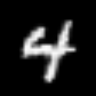

In [ ]:
fake_images *= 255.0
converted_images = fake_images.astype(np.uint8)
converted_images = tf.image.resize(converted_images, (96, 96)).numpy().astype(np.uint8)
imageio.mimsave("animation.gif", converted_images, fps=1)
embed.embed_file("animation.gif")

Zachęcam do eksperymentowania z notatnikiem, prób zwiększania liczby warstw, funkcji aktywacji, rodzaju maski, liczby filtrów itp.

<center>
Projekt współfinansowany ze środków Unii Europejskiej w ramach Europejskiego Funduszu Rozwoju Regionalnego
Program Operacyjny Polska Cyfrowa na lata 2014-2020,
Oś Priorytetowa nr 3 "Cyfrowe kompetencje społeczeństwa" Działanie  nr 3.2 "Innowacyjne rozwiązania na rzecz aktywizacji cyfrowej"
Tytuł projektu:  „Akademia Innowacyjnych Zastosowań Technologii Cyfrowych (AI Tech)”
    </center>